In [1]:
import mysql.connector
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None
import seaborn as sn

In [2]:
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                              host='127.0.0.1',
                              database='computervision')
cursor = cnx.cursor()
headers = {"x-api-key": "M7HSjQNeTfai6l7JUiDZB8XYc85BHnHt3R0NXSEd"}
#pg = ProxyGenerator()

# Create train dataset

In [5]:
train_papers = []
with open(r'./test_papers.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        train_papers.append(x)
in_params = ','.join(['%s'] * len(train_papers))


In [6]:
cursor.execute("select distinct p2.`primary author` from Papers p, referencedBy b, Papers p2 where p.PaperID in (%s) and p.PaperID = b.ReferencedByID and p2.PaperID = b.ReferenceID" % in_params, train_papers)
len(cursor.fetchall())

12408

In [7]:
cursor.execute("select p.PaperID, a.Gender, aff.Country, aff.AffiliationID, p.`primary author`, GROUP_CONCAT(a2.Gender), GROUP_CONCAT(aff2.Country), GROUP_CONCAT(aff2.AffiliationID), GROUP_CONCAT(p2.`primary author`) from Papers p, Authors a, affiliatedTo af, Affiliations aff, referencedBy b, Papers p2, Authors a2, affiliatedTo af2, Affiliations aff2 where p.PaperID in (%s) and p.`primary author` = a.AuthorID and p.PaperID = b.ReferencedByID and b.ReferenceID = p2.PaperID and p2.`primary author` = a2.AuthorID and a.AuthorID = af.AuthorID and af.affiliatedTo = aff.AffiliationID and a2.AuthorID = af2.AuthorID and af2.affiliatedTo = aff2.AffiliationID  group by p.PaperID, a.Gender, aff.Country, aff.AffiliationID" % in_params, train_papers)
complete_information = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "Gender", "Country", "Affiliation", "Author", "Gender_references", "Country_references", "Affiliation_references", "Author_references"])
cursor.execute("select p.PaperID, group_concat(aff.AffiliationID), group_concat(aff.Country), group_concat(a.AuthorID) from Papers p, authoredBy b, Authors a, affiliatedTo af, Affiliations aff where p.PaperID in (%s) and p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID and a.AuthorID = af.AuthorID and af.affiliatedTo = aff.AffiliationID group by p.PaperID" % in_params, train_papers)
authors_country_affiliation = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "author_affiliations", "author_countries", "author_authors"])
#authors_country_affiliation
complete_information = pd.merge(authors_country_affiliation, complete_information, on="PaperID")

In [221]:
def most_frequent_without_ties(a, top_n):
    current_list = {x: a for x,a in sorted(Counter(a).items(), key=lambda x: x[1], reverse=True)}
    top_n_list = []
    not_top_n_list = []
    for idx, key in enumerate(current_list.items()):
        if idx < top_n:
            top_n_list.append((key[0], key[1]))
        else:
            not_top_n_list.append(key[1])
    # remove ties
    smallest_top_n = top_n_list[-1][1]
    if smallest_top_n in not_top_n_list:
        top_n_list = [x for x in top_n_list if x[1] != smallest_top_n]
    top_n_list = [x[0] for x in top_n_list]
    return ",".join(top_n_list)

# Gender

In [30]:
gender_predictor = complete_information[["PaperID", "Gender", "Gender_references"]]
gender_predictor["prediction"] = 0
gender_predictor["match"] = 0
gender_predictor["Gender_references"] = gender_predictor["Gender_references"].apply(lambda x: np.count_nonzero(np.array(x.split(","), dtype="int"))/len(x.split(",")))

In [31]:
threshold = 0.19230769230769232

In [32]:
gender_predictor['prediction'] = np.where(gender_predictor["Gender_references"] >= threshold , 1, 0)
gender_predictor["match"] = (gender_predictor["Gender"] == gender_predictor["prediction"])
accuracy = np.mean(gender_predictor["match"].to_numpy())
accuracy

0.6958250497017893

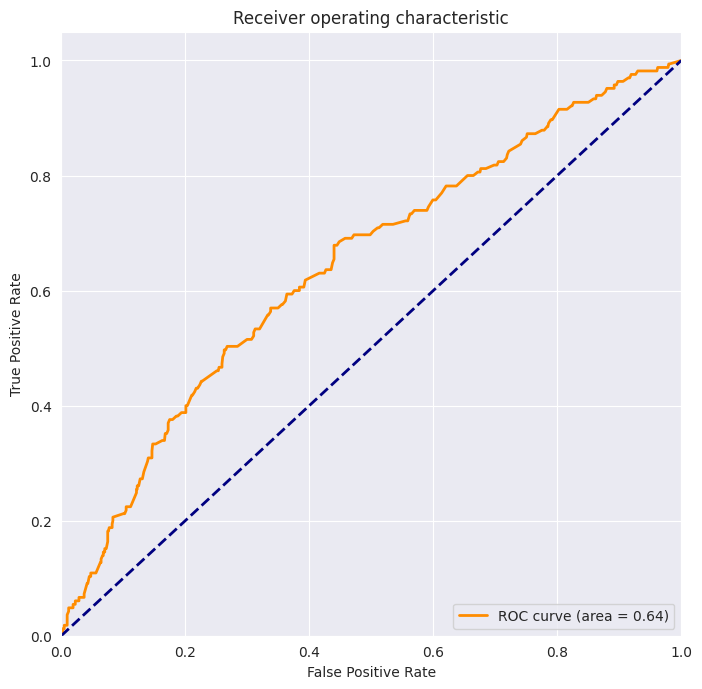

(0.3912009512485137, 0.6060606060606061, 135)

In [36]:
fpr, tpr, thresholds = roc_curve(gender_predictor["Gender"].to_numpy(), gender_predictor["Gender_references"].to_numpy())
roc_auc = auc(fpr, tpr)
figure(figsize=(8, 8),dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
idx = np.argmin(np.abs(tpr - (1 - fpr)))
best_threshold = thresholds[idx]
fpr[idx], tpr[idx], idx

# Country

In [363]:
country_predictor = complete_information[["PaperID", "Country", "Country_references", "author_countries"]]
country_predictor["prediction"] = country_predictor["Country_references"].apply(lambda x: most_frequent_without_ties(x.split(","), 1))
country_predictor["match"] = 0
country_predictor["match_any"] = 0
for idx, country_prediction in enumerate(country_predictor["prediction"]):
    if country_predictor["Country"][idx] in country_prediction.split(","):
        country_predictor.loc[idx, "match"] = 1
#np.mean(country_predictor["match_any"])
#country_predictor["match"] = (country_predictor["Country"] == country_predictor["prediction"])
np.mean(country_predictor["match"])

0.3190854870775348

In [308]:
for idx, author_country in enumerate(country_predictor["author_countries"]):
    if len(set(country_predictor["prediction"][idx].split(",")).intersection(set(author_country.split(",")))) > 0:
        country_predictor.loc[idx, "match_any"] = 1
np.mean(country_predictor["match_any"])

0.9831013916500994

In [219]:
most_frequent_countries = ["China", "United States", "Hong Kong", "Germany", "United Kingdom", "Australia"]
country_predictor_most = country_predictor[country_predictor["Country"].isin(most_frequent_countries)]
cm = confusion_matrix(country_predictor_most["Country"].to_numpy(), country_predictor_most["prediction"].to_numpy(), labels=most_frequent_countries)



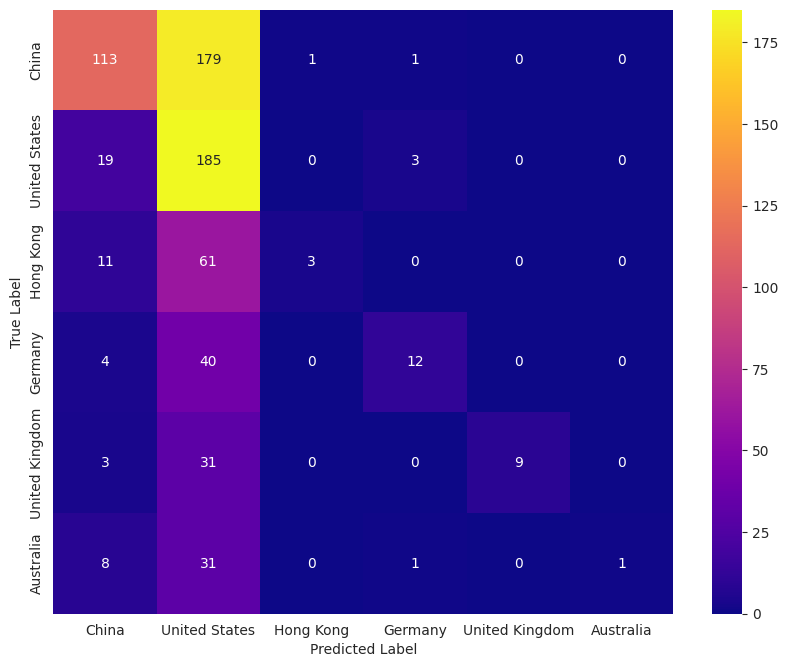

In [123]:
figure(figsize=(10, 8),dpi=100)
sn.heatmap(cm, annot=True, xticklabels=most_frequent_countries, yticklabels=most_frequent_countries, cmap="plasma", fmt='g')
#plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

# Affiliation

In [364]:
affiliation_predictor = complete_information[["PaperID", "Affiliation", "Affiliation_references", "author_affiliations"]]
affiliation_predictor["prediction"] = affiliation_predictor["Affiliation_references"].apply(lambda x: most_frequent_without_ties(x.split(","), 1))
affiliation_predictor["match_any"] = 0
affiliation_predictor["match"] = 0
affiliation_predictor["match"] = affiliation_predictor["match"].astype("int64")

for idx, country_prediction in enumerate(affiliation_predictor["prediction"]):
    if str(affiliation_predictor["Affiliation"][idx]) in country_prediction.split(","):
        affiliation_predictor.loc[idx, "match"] = 1

np.mean(affiliation_predictor["match"])

0.20675944333996024

In [306]:
for idx, author_country in enumerate(affiliation_predictor["author_affiliations"]):
    if len(set(affiliation_predictor["prediction"][idx].split(",")).intersection(set(author_country.split(",")))) > 0:
        affiliation_predictor.loc[idx, "match_any"] = 1
np.mean(affiliation_predictor["match_any"])

0.9075546719681908

# Author

In [402]:
author_predictor = complete_information[["PaperID", "Author", "Author_references", "author_authors"]]
author_predictor["prediction"] = author_predictor["Author_references"].apply(lambda x: most_frequent_without_ties(x.split(","), 1))
author_predictor["match_any"] = 0
author_predictor["match"] = 0
author_predictor["match"] = author_predictor["match"].astype("int64")

for idx, country_prediction in enumerate(author_predictor["prediction"]):
    if str(author_predictor["Author"][idx]) in country_prediction.split(","):
        author_predictor.loc[idx, "match"] = 1
np.mean(author_predictor["match"])

0.17693836978131214

In [403]:
for idx, author_country in enumerate(author_predictor["author_authors"]):
    if len(set(author_predictor["prediction"][idx].split(",")).intersection(set(author_country.split(",")))) > 0:
        author_predictor.loc[idx, "match_any"] = 1
np.mean(author_predictor["match_any"])

0.20874751491053678

# Impact of h-index and paper count

In [377]:
cursor.execute("select p.PaperID, a.PaperCount, a.hIndex from Papers p, Authors a where p.PaperID in (%s) and p.`primary author` = a.AuthorID" % in_params, train_papers)
author_information = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "PaperCount", "hIndex"])
all_information = pd.merge(author_information, complete_information, on="PaperID")

In [409]:
all_information["country_acc"] = country_predictor["match"]
all_information["affiliation_acc"] = affiliation_predictor["match"]
all_information["author_acc"] = author_predictor["match"]
all_information["author_acc_any"] = author_predictor["match_any"]

0       18
1       13
2        4
3        6
4        6
        ..
1001    18
1002     5
1003     2
1004     7
1005     6
Name: hIndex, Length: 1006, dtype: int64

In [422]:
bucket = all_information.loc[(all_information["PaperCount"] >= 60) & (all_information["PaperCount"] < 80)]
country_accuracy = np.mean(bucket["country_acc"].to_numpy())
affiliation_accuracy = np.mean(bucket["affiliation_acc"].to_numpy())
author_accuracy = np.mean(bucket["author_acc"].to_numpy())
author_accuracy_any = np.mean(bucket["author_acc_any"].to_numpy())
country_accuracy, affiliation_accuracy, author_accuracy, author_accuracy_any

(0.36, 0.36, 0.16, 0.16)

In [419]:
bucket

,PaperID,PaperCount,hIndex,author_affiliations,author_countries,author_authors,Gender,Country,Affiliation,Author,Gender_references,Country_references,Affiliation_references,Author_references,country_acc,affiliation_acc,author_acc,author_acc_any
0,002a17b6956ead1668bf2aa8241bebb14c5268c0,66,18,"3810,102437,344,33552","China,United States,China,United States","2070183551,145690248,3430743,2108058646",0,United States,33552,2108058646,"1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...","Hong Kong,China,United States,Austria,United S...","300,1446,5974,97398,5974,104068,1304,143,1283,...","2068605434,3712271,34192119,50875121,34192119,...",1,0,0,0
79,0f01088765729402e903ec560f3246f884d324f8,73,18,"5908,35389,5908,60833,32116,60820","France,Germany,France,France,China,France","143991676,2103464,2462253,2462253,3009919,3441800",0,China,32116,3009919,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...","Australia,China,Hong Kong,Canada,United States...","68518,32116,300,15,269,262,1140,43,1182,25,43,...","6965856,3009919,2107958221,1699645,147495445,1...",0,0,0,0
176,23e0e88c5abcda4b363f96e3d639ac43a85f5e7e,60,9,"351,351,351,5421,2025","China,China,China,United States,Netherlands","1454206009,46399275,3016489,2904100,144049156",0,China,351,3016489,"0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...","China,United States,China,China,France,United ...","351,61186,351,351,102815,61186,31479,1192,9733...","1454206009,32627314,2069706514,2069706514,2300...",0,1,0,0
202,28c33e84a0a1965b7ed5d56d11846a19cb04023a,72,16,"412,32074","United States,Canada","32117189,98655520",0,United States,412,32117189,"0,0,1,0,0,0,1,0,0,0,0,0","Belgium,Canada,United States,United States,Can...","61154,49,5974,412,143,99986,716,32116,38493,31...","9907891,2704494,2107904708,32117189,1702328,39...",1,0,0,0
256,35cbed3da1d500675bdfada102dafb0139c60d12,67,13,"33978,2344,35282,3770","Netherlands,Italy,Italy,China","1703601,40811261,2933549,2069512103",0,Italy,35282,2933549,"0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...","Canada,China,Australia,Italy,United Kingdom,Un...","143,32116,36986,36502,213,61186,269,102419,213...","2064160,143932869,7435343,1429191945,22235380,...",0,0,0,0
257,35cea14085a503dca638fef392bb7fe293ffafcd,66,24,"102437,102437,1438,1453","United States,United States,United States,Unit...","2141735343,2145253136,36610242,49829905",0,United States,1438,36610242,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","United States,China,China,United States,Austra...","124,40094,32116,25,1140,1140,97291,143,1026,41...","33493200,2131880649,145815850,2788204,40219976...",1,0,0,0
381,525259f2841b98dbd70a34564e3c349d2a997034,62,15,"57471,57471","Czechia,Czechia","1805301,51122311",0,Czechia,57471,51122311,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...","United States,Czechia,Czechia,United Kingdom,C...","100262,57471,57471,1200,29,57471,57471,57471,5...","70524822,51122311,51122311,3086037,152904589,4...",1,1,1,1
472,6a1c68663a91784e5e7948ed24a0321a58db0e02,65,27,"2125,102865,327","United States,United States,United States","1397590190,1910738,2631712",0,United States,102865,1910738,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...","United States,Germany,United States,Germany,Un...","31475,33179,41698,97337,5974,1185,99986,213,59...","1687325,1486455596,34939951,1707625,35681810,1...",1,0,0,0
522,76d3b30bfbab5b22a022649abdb07f1f0ce6eb7f,76,24,"33292,33292,33292,33292,33292,33292","Italy,Italy,Italy,Italy,Italy,Italy","10261545,121670758,2509750,2607607,80804241,93...",0,Italy,33292,2509750,"0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...","Taiwan,United States,United States,Germany,Uni...","1262,71759,61186,32786,71759,1977,124,5974,733...","2118830989,81720702,33810877,102880243,8172070...",0,0,0,0
552,7e171206b7266f026541fcfd0a724a20eba4dcd8,73,26,"716,41658,103353,41658,41658,41658,7331","China,China,China,China,China,China,Hong Kong","2153576358,3409475,3318404,2145057399,21166408...",0,China,41658,3409475,"0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

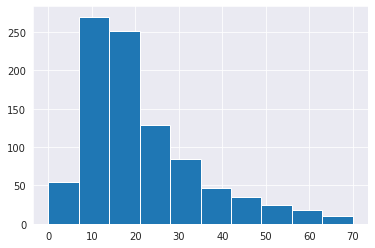

In [343]:
plt.hist(all_information["PaperCount"].to_numpy(), range=(0,70))
plt.show()

# Author as input feature

In [3]:
# Fetch Papers with one author
#cursor.execute("SET SESSION group_concat_max_len=15000;")
cursor.execute("select p.PaperID as PaperID, GROUP_CONCAT(distinct b.AuthoredByID) as authors, count(*) as authorCount,p.Leaf, Avg(a.hIndex) from Papers p, authoredBy b, Authors a where p.PaperID = b.PaperID and b.AuthoredByID != 0 and b.AuthoredByID = a.AuthorID group by p.PaperID, p.Leaf")
temp_table = cursor.fetchall()
temp_table_df = pd.DataFrame(temp_table, columns =['ReferencedByID', 'authors', 'authorCount', "isLeaf", "paperCount"])
temp_table_df2 = pd.DataFrame(temp_table, columns =['ReferenceID', 'authors', 'authorCount', "isLeaf", "paperCount"])
cursor.execute("select * from referencedBy")
temp_table_reference_by = cursor.fetchall()
reference_by_df = pd.DataFrame(temp_table_reference_by, columns =['ReferenceID', 'ReferencedByID'])
referenced_paper = temp_table_df[temp_table_df["isLeaf"] == 0]

In [4]:
all_references = pd.merge(referenced_paper, reference_by_df, on="ReferencedByID")
all_references_w_authors = pd.merge(all_references, temp_table_df2, on="ReferenceID")

In [5]:
final_table = all_references_w_authors.groupby(["ReferencedByID","authors_x", "authorCount_x", "paperCount_x"], as_index = False).agg({'authors_y': ','.join})

In [6]:
# Check for authorCount = 1
#final_table_one_author = final_table.loc[(final_table["paperCount_x"] >= 250) & (final_table["paperCount_x"] > 250)]
#print(len(final_table_one_author))
#final_table_one_author = final_table
#&  & (final_table["paperCount_x"] >= 5) & (final_table["paperCount_x"] < 10)
#final_table_one_author = final_table[final_table["ReferencedByID"].isin(val_list)]
final_table_one_author = final_table[final_table["authorCount_x"] == 1]
final_table_one_author

,ReferencedByID,authors_x,authorCount_x,paperCount_x,authors_y
94,0046675571f67bda5ab8f2cfed9d79fc8b2b7035,40433860,1,8.0000,"1771551,3080683,39353098,1726807,2503659,16956..."
139,006b3a1acbb37136b21dbe49b3e766093069b74d,46195895,1,10.0000,"1771551,3080683,39353098,1726807,2503659,13936..."
170,00881ae23d035b995b6a134a44ef17e9c1d6dc3a,144806973,1,10.0000,"1695689,1803520,1678311,1726807,1763295,209477..."
188,009444a451a3ae1d636ba7620e9bacb87f2d45e8,3189216,1,8.0000,"2423230,145795454,1710384,1869571,38592832,144..."
280,00d84dd20595be5f3c5ea87030d308d746e8fbc4,48797862,1,12.0000,"1771551,3080683,39353098,145024664,1846258,191..."
...,...,...,...,...,...
74951,ff5e888c01eb11f03b0b2db8916635619783992c,2060229206,1,2.0000,"143774737,144564063,145162067,2078931040,28482..."
74987,ff7de2ea4d21e7d32d7f07e07fd278bebf6b5d66,8391248,1,4.0000,"35238678,145404204,1695527,1756979,2048069,251..."
75019,ffa88047613529fe4447d0d00818d8b6e984c874,2064602886,1,6.0000,"1678311,41016725,1722180,1737568,1754860,20675..."
75030,ffb6002dfcadee2ffdaed9f2860a94c8e30ba85c,2092157951,1,2.0000,"1771551,3080683,39353098,1695689,1701686,20641..."


### Simple Count approach

In [9]:
def author_matches(top_n, cited_list, cur_authors, remove_ties = True):
    most_cited = cited_list[:top_n]
    list_index = most_cited[-1][1]
    most_cited_author_ids = [x[0] for x in most_cited if x[1] == list_index]
    all_cited_with_index = [x[0] for x in cited_list if x[1] == list_index]

    for author in all_cited_with_index:
        if author not in most_cited_author_ids:
            most_cited = filter(lambda x: x[1] != list_index, most_cited)

    for author in cur_authors:
        if author in [author[0] for author in most_cited]:
            return True
    return False

In [10]:
totalCount = 0
totalCorrect = 0
matched = []
for row in final_table_one_author.iterrows():
    most_cited_authors = []
    authors = row[1]["authors_x"].split(",")
    cited_authors = row[1]["authors_y"].split(",")
    all_cited = dict(Counter(cited_authors))
    all_cited_sorted = sorted([(cited, all_cited[cited]) for cited in all_cited], key=lambda x:x[1], reverse=True)
    if author_matches(1, all_cited_sorted, authors):
        totalCorrect += 1
        matched.append(row[1]["ReferencedByID"])
    totalCount += 1
totalCorrect/totalCount

0.47368421052631576


| 1       | 2     | 3     | 4     | max   |
|---------|-------|-------|-------|-------|
| 22      | 27.84 | 31.44 | 33.33 | 56.35 |
| 18.88   | 25.07 | 29.7  | 31.72 | 63.28 |
| 25.57   | 33.19 | 37.08 | 40.33 | 71.93 |
| 26.88   | 35.29 | 39.78 | 43.99 | 78.49 |
|---------|-------|-------|-------|-------|
| 25.24 | 32.57 | 37.03 | 40.06 | 71.29 |

### Remove Ties

| 1         | 2       | 3       | 4       | max   |
|-----------|---------|---------|---------|-------|
| 17.9      | 24.57   | 28.35   | 30.58   | 56.35 |
| 13.36     | 19.02   | 20.75   | 23.06   | 63.28 |
| 18.36     | 22.80   | 25.09   | 25.92   | 71.93 |
| 19.55     | 24.24   | 26.00   | 25.12   | 78.49 |
| --------- | ------- | ------- | ------- |-------|
| 18.25     | 22.60    | 24.34   | 25.52   | 71.29 |

### Weight per paper

| 1         | 2       | 3       | 4       | max   |
|-----------|---------|---------|---------|-------|
| 23.54     | 30.07   | 33.68   | 37.11   | 56.35 |
| 15.75     | 20.37   | 24.18   | 24.93   | 63.28 |
| 16.98     | 22.52   | 26.06   | 29.38   | 71.93 |
| 17.79     | 22.29   | 24.93   | 26.78   | 78.49 |
| --------- | ------- | ------- | ------- |-------|
| 17.96     | 22.84    | 25.90   | 28.05   | 71.29 |

All papers & Top 1 of all authorCounts for average papercount
853 |  882 | 839 | 944 | 667 | 1081

| < 33 | 33-66 | 66-100 | 100-150 | 150-200 | >200   |
|------|-------|--------|---------|---------|--------|
| 5.81 | 14.17  | 16.81  | 20.97   | 25.64   | 24.14  |
| 4.8 | 12.7 | 18.47 | 22.03 | 21.6 | 26.46 |


Papers with 1 author

all papercounts: 23.54
>= 25: 32.47
>= 50: 39.84
>= 100: 44.29
>= 150: 48.86
> Top 10: 50%

Average hIndex

[0.1796429927838967,
 0.21138211382113822,
 0.2370266479663394,
 0.25058823529411767,
 0.26288659793814434]


### Weighted simple count approach

In [11]:
def weighted_simple_count(final_table_one_author):
    totalCount = 0
    totalCorrect = 0
    print(len(final_table_one_author))
    for row in final_table_one_author.iterrows():
        referenced_papers = all_references_w_authors[all_references_w_authors["ReferencedByID"] == row[1]["ReferencedByID"]]
        authors = row[1]["authors_x"].split(",")
        referenced_authors = {}
        for ref in referenced_papers.iterrows():
            ref_authors = ref[1]["authors_y"].split(",")
            weight = 1/len(ref_authors)
            for ref_author in ref_authors:
                if ref_author not in referenced_authors:
                    referenced_authors[ref_author] = 0
                referenced_authors[ref_author] += weight

        all_cited_sorted = sorted([(cited, referenced_authors[cited]) for cited in referenced_authors], key=lambda x:x[1], reverse=True)
        if author_matches(1, all_cited_sorted, authors):
            totalCorrect += 1
        totalCount += 1
    if totalCount == 0:
        return 0
    return totalCorrect/totalCount

In [12]:
weighted_simple_count(final_table_one_author)

19


0.47368421052631576

In [172]:
def hIndex_accuracies(buckets, max_value, final_table_temp):
    start_value = 0
    accuracies = []
    break_out = False
    while not break_out:
        bucket_value = start_value + buckets
        if start_value >= max_value:
            bucket_value = 100000
            break_out = True
        filtered_table = final_table_temp.loc[(final_table_temp["paperCount_x"] >= start_value)]
        print(len(filtered_table))
        accuracies.append(weighted_simple_count(filtered_table))
        start_value += buckets
    return accuracies

In [176]:
hIndex_accuracies(10, 40, final_table)

5266
4182
2852
1700
970


[0.1796429927838967,
 0.21138211382113822,
 0.2370266479663394,
 0.25058823529411767,
 0.26288659793814434]

# Affiliation

In [9]:
cursor.execute("select p.PaperID, count(*) as authorCount from authoredBy a, Papers p where p.PaperID = a.PaperID and p.Leaf = 0 and a.AuthoredByID != 0 group by p.PaperID")
authorCount = cursor.fetchall()
temp_authorCount_table_df = pd.DataFrame(authorCount, columns=["PaperID_y", "authorCount"])

In [11]:
cursor.execute("select p.PaperID, group_concat(t.affiliatedTo) from Authors a, affiliatedTo t, Papers p, authoredBy b where p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID and a.AuthorID = t.AuthorID and t.affiliatedTo != 1 group by p.PaperID")
grouped_affiliations = cursor.fetchall()
cursor.execute("select * from referencedBy")
references = cursor.fetchall()
temp_ref_table_df = pd.DataFrame(references, columns=["reference_id", "referenced_by_id"])
temp_aff_table_df = pd.DataFrame(grouped_affiliations, columns =['PaperID', 'affiliations'])

In [12]:
temp1 = pd.merge(temp_ref_table_df, temp_aff_table_df, how="inner",left_on="referenced_by_id", right_on="PaperID")
temp1 = pd.merge(temp_aff_table_df, temp1, how="inner", left_on="PaperID", right_on="reference_id")
temp1 = pd.merge(temp_authorCount_table_df, temp1, how="inner", on="PaperID_y")
final_table = temp1.groupby(["PaperID_y","affiliations_y", "authorCount"], as_index = False).agg({'affiliations_x': ','.join})
final_table_filtered = final_table

In [336]:
total_count = 0
correct_count = 0
for row in final_table_filtered.iterrows():
    target_affiliations = row[1]["affiliations_y"].split(",")
    input_affiliations = row[1]["affiliations_x"].split(",")
    all_cited_affiliations = dict(Counter(input_affiliations))
    sorted_affiliations = sorted(all_cited_affiliations.items(), key=lambda x: x[1], reverse=True)
    if author_matches(4, sorted_affiliations, target_affiliations):
        correct_count += 1
    total_count += 1
correct_count/total_count

0.41933445661331087

In [371]:
# Weighted affiliations
total_count = 0
correct_count = 0
for row in final_table_filtered.iterrows():
    target_affiliations = row[1]["affiliations_y"].split(",")
    referenced_affiliations = temp1[temp1["referenced_by_id"] == row[1]["PaperID_y"]]
    all_cited_affiliations = {}
    for ref in referenced_affiliations.iterrows():
        ref_affiliations = ref[1]["affiliations_x"].split(",")
        weight = 1/len(ref_affiliations)
        for ref_author in ref_affiliations:
            if ref_author not in all_cited_affiliations:
                all_cited_affiliations[ref_author] = 0
            all_cited_affiliations[ref_author] += weight
    sorted_affiliations = sorted(all_cited_affiliations.items(), key=lambda x: x[1], reverse=True)
    if author_matches(40000, sorted_affiliations, target_affiliations):
        correct_count += 1
    total_count += 1
correct_count/total_count

0.8159224936815501

# Solution

Remove Ties no weights:

| 1         | 2       | 3       | 4       | max     |
|-----------|---------|---------|---------|---------|
| 19.18     | 31.2    | 37.34   | 44.50   | 76.47   |
| 19.10     | 27.74   | 32.84   | 36.90   | 76.75   |
| 25.50     | 38.88   | 38.29   | 41.26   | 80.74   |
| 25.50     | 35.10   | 39.10   | 41.00   | 83.50   |
| --------- | ------- | ------- | ------- | ------- |
| 25.93     | 34.81   | 38.92   | 41.93   | 81.59   |

Including weights:

| 1         | 2       | 3       | 4      | max     |
|-----------|---------|---------|--------|---------|
| 31.97     | 42.46   | 48.59   | 52.69  | 76.47   |
| 23.77     | 33.54   | 40.54   | 44.08  | 76.75   |
| 28.85     | 33.09   | 43.49   | 46.91  | 80.74   |
| 26.30     | 37.10   | 45.90   | 49.00  | 83.50   |
| --------- | ------- | ------- | ------ | ------- |
| 29.00     | 39.44   | 46.08   | 49.01  | 81.59   |


# Country

In [6]:
cursor.execute("select p.PaperID, group_concat(af.Country) from Authors a, affiliatedTo t, Papers p, authoredBy b, Affiliations af where p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID and a.AuthorID = t.AuthorID and t.affiliatedTo = af.AffiliationID and af.Country is not NULL group by p.PaperID")
grouped_affiliations = cursor.fetchall()
cursor.execute("select * from referencedBy")
references = cursor.fetchall()
temp_ref_table_df = pd.DataFrame(references, columns=["reference_id", "referenced_by_id"])
temp_aff_table_df = pd.DataFrame(grouped_affiliations, columns =['PaperID', 'country'])

In [14]:
temp1 = pd.merge(temp_ref_table_df, temp_aff_table_df, how="inner",left_on="referenced_by_id", right_on="PaperID")
temp1 = pd.merge(temp_aff_table_df, temp1, how="inner", left_on="PaperID", right_on="reference_id")
temp1 = pd.merge(temp_authorCount_table_df, temp1, how="inner", on="PaperID_y")
final_table = temp1.groupby(["PaperID_y","country_y", "authorCount"], as_index = False).agg({'country_x': ','.join})
final_table = final_table

In [18]:
# weighted countries
total_count = 0
correct_count = 0
for row in final_table.iterrows():
    target_country = row[1]["country_y"].split(",")
    input_country = row[1]["country_x"].split(",")
    all_cited_countries = dict(Counter(input_country))
    sorted_countries = sorted(all_cited_countries.items(), key=lambda x: x[1], reverse=True)
    if author_matches(1, sorted_countries, target_country):
        correct_count += 1
    total_count += 1
correct_count/total_count

0.4782334384858044

In [19]:
total_count = 0
correct_count = 0
for row in final_table.iterrows():
    target_country = row[1]["country_y"].split(",")
    referenced_countries = temp1[temp1["referenced_by_id"] == row[1]["PaperID_y"]]
    all_cited_countries = {}
    for ref in referenced_countries.iterrows():
        ref_countries = ref[1]["country_x"].split(",")
        weight = 1/len(ref_countries)
        for ref_country in ref_countries:
            if ref_country not in all_cited_countries:
                all_cited_countries[ref_country] = 0
            all_cited_countries[ref_country] += weight
    sorted_countries = sorted(all_cited_countries.items(), key=lambda x: x[1], reverse=True)
    if author_matches(1, sorted_countries, target_country):
        correct_count += 1
    total_count += 1
correct_count/total_count

0.44647739221871713

# Solution

Remove Ties no weights:

| 1         | 2       | 3       | 4      | max     |
|-----------|---------|---------|--------|---------|
| 29.77     | 47.33   | 58.52   | 69.21  | 89.82   |
| 39.26     | 55.82   | 63.59   | 68.51  | 89.13   |
| 46.54     | 64.83   | 71.60   | 75.84  | 92.86   |
| 52.75     | 69.73   | 75.12   | 79.12  | 95.00   |
| --------- | ------- | ------- | ------ | ------- |
| 47.82     | 64.98   | 71.40   | 76.28  | 92.91   |

Remove Ties with weights:

| 1         | 2       | 3       | 4      | max     |
|-----------|---------|---------|--------|---------|
| 29.77     | 47.33   | 58.52   | 69.21  | 89.82   |
| 39.26     | 55.82   | 63.59   | 68.51  | 89.13   |
| 46.54     | 64.83   | 71.60   | 75.84  | 92.86   |
| 52.75     | 69.73   | 75.12   | 79.12  | 95.00   |
| --------- | ------- | ------- | ------ | ------- |
| 47.82     | 64.98   | 71.40   | 76.28  | 92.91   |

# Gender

In [32]:
cursor.execute("select p.PaperID as PaperID, avg(a.Gender) as g from Papers p, authoredBy b, Authors a where p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID group by p.PaperID")
avg_gender_distribution = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "gender"])
cursor.execute("select p.PaperID, b.ReferenceID from Papers p, referencedBy b where p.Leaf = FALSE and p.Pub_Year >= 2015 and p.authorCount <= 5 and p.PaperID = b.ReferencedByID")
references_df = pd.DataFrame(cursor.fetchall(), columns=["PaperID", "ReferenceID"])
temp = pd.merge(avg_gender_distribution, references_df, on="PaperID")
references_df_w_gender = pd.merge(temp, avg_gender_distribution, left_on="ReferenceID", right_on="PaperID")

In [33]:
references_df_w_gender2 = references_df_w_gender.groupby(["PaperID_x", "gender_x"], as_index=False)["gender_y"].mean()

In [34]:
references_df_w_gender2

,PaperID_x,gender_x,gender_y
0,0000c8b2b59cd81add0632a0cdda2db5f5908789,0.3333,0.122833
1,0000fcfd467a19cf0e59169c2f07d730a0f3a8b9,0.2500,0.168243
2,000178cd12c8a6e5da8215b6365fae03c20fd18d,0.2000,0.073711
3,00035282b3fc11736967f03b6750b2ffc5fef42f,0.0000,0.183327
4,0003b8fef7d5e048a9870cdafdec27af129ae990,0.2000,0.124850
...,...,...,...
54961,fffb53e84dd47049f5d2b5baa9dbfeeffc1d4a02,0.0000,0.205089
54962,fffb972e3e8234bfa45d75bd5edd9a99b18f696b,0.0000,0.106893
54963,fffc9675649ee6b5b4b46f61de80abb8c11a1163,0.0000,0.219570
54964,ffff18e40754bc455c36f52b000857d4e23dcdb4,0.5000,0.183958


In [35]:
references_df_w_gender2.groupby("gender_x").agg({'PaperID_x':'size', 'gender_y':'mean'}).rename(columns={'gender_y':'mean', 'PaperID_x':'count'}).reset_index()

,gender_x,count,mean
0,0.0000,29707,0.137684
1,0.2000,4587,0.153036
2,0.2500,5653,0.153217
3,0.3333,5103,0.154747
4,0.4000,2139,0.163952
5,0.5000,4676,0.164572
6,0.6000,617,0.177195
7,0.6667,1187,0.173775
8,0.7500,367,0.186108
9,0.8000,108,0.184333


In [6]:
references_df_w_gender.groupby(["PaperID_x", "gender_x"], as_index=False)["gender_y"].mean().groupby("gender_x")["gender_y"].mean()

gender_x
0.0000    0.137099
0.2500    0.153212
0.3333    0.154760
0.5000    0.164561
0.6667    0.173640
0.7500    0.186201
1.0000    0.184991
Name: gender_y, dtype: float64

In [ ]:
cursor.execute("select p.PaperID, t.g as AuthorGender, avg(t2.g) as ReferenceGender from Papers p, temp t, referencedBy b, temp2 t2 where p.Leaf = 0 and p.Pub_Year < 2021 and p.PaperID = t.PaperID and b.ReferencedByID = p.PaperID and b.ReferenceID = t2.PaperID group by p.PaperID, t.g")
cursor.fetchall()

In [63]:
cursor.execute("select p.PaperID, group_concat(a.Gender) from Papers p, authoredBy b, Authors a where p.PaperID = b.PaperID and b.AuthoredByID = a.AuthorID and a.Gender is not null group by p.PaperID")
grouped_gender = cursor.fetchall()
temp_gender_table_df = pd.DataFrame(grouped_gender, columns =['PaperID', 'gender'])
temp1 = pd.merge(temp_ref_table_df, temp_gender_table_df, how="inner",left_on="referenced_by_id", right_on="PaperID")
temp1 = pd.merge(temp_gender_table_df, temp1, how="inner", left_on="PaperID", right_on="reference_id")
temp1 = pd.merge(temp_authorCount_table_df, temp1, how="inner", on="PaperID_y")
final_table = temp1.groupby(["PaperID_y","gender_y", "authorCount"], as_index = False).agg({'gender_x': ','.join})
final_table = final_table[final_table["authorCount"] == 2]
final_table

,PaperID_y,gender_y,authorCount,gender_x
1,00202f23535fcef5043ec854e18cf0bd5334ced2,"0,0",2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
2,0024437badc418b788a7c3459441bb811eab7670,"1,0",2,"0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,..."
5,0049f82713993ba0da269a8160c8b825299ba397,"1,0",2,"0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0"
17,00ce3ccd8062f3191986ad1a4e9099a784a39a5f,"0,0",2,"0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,..."
20,00e030562704fe34c82c871148864e6092fde0f9,"1,0",2,"0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,..."
...,...,...,...,...
5250,ff0b456110a7c2612fcb71860fac8efcb9dd0dbb,"0,0",2,"0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,..."
5254,ff748e293e9d37aa5399465ba34032038dfc608e,"0,1",2,"0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,..."
5256,ff8900a0ea63210a08ad3bd698e3974e1021d03d,"0,0",2,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
5258,ffa8b7851070676f10e7904f02d47ead448da46d,"0,0",2,"0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,..."


In [74]:
male_dist = []
female_dist = []
for row in final_table.iterrows():

    input_gender = row[1]["gender_x"].split(",")
    distribution_females = input_gender.count("1")/len(input_gender)
    #print(distribution_females)
    if row[1]["gender_y"] == "1,0" or row[1]["gender_y"] == "0,1":
        female_dist.append(distribution_females)
    elif row[1]["gender_y"] == "0,0":
        male_dist.append(distribution_females)

In [13]:
print(sum(male_dist)/len(male_dist))
print(sum(female_dist)/len(female_dist))
print((sum(female_dist)+sum(male_dist))/(len(female_dist)+len(male_dist)))

NameError: name 'male_dist' is not defined

In [61]:
correct = 0
total = 0
for row in final_table.iterrows():
    input_gender = row[1]["gender_x"].split(",")
    distribution_females = input_gender.count("1")/len(input_gender)
    if distribution_females > 0.9:
        if row[1]["gender_y"] == "1":
            correct += 1
    else:
        if row[1]["gender_y"] == "0":
            correct += 1
    total += 1
correct/total

0.8844827586206897

Single female authors tend to cite other females with 25% whereas males have a lower female distribution by 14 %
But how does the distribution for multiple authors look like?

In [476]:
female_distribution = pd.DataFrame(columns=["author_distr", "ref_distr"])
for row in final_table.iterrows():
    target_gender = row[1]["gender_y"].split(",")
    target_females = target_gender.count("1")/len(target_gender)
    feature_gender = row[1]["gender_x"].split(",")
    feature_females = feature_gender.count("1")/len(feature_gender)
    female_distribution.loc[len(female_distribution)] = [target_females,feature_females]

female_distribution = female_distribution.groupby(["author_distr"], as_index = False).mean("ref_distr").sort_values("author_distr")
author_dist = female_distribution["author_distr"].to_numpy()
ref_dist = female_distribution["ref_distr"].to_numpy()

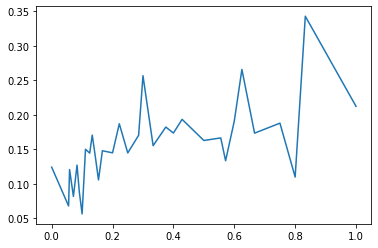

In [478]:
plt.plot(author_dist, ref_dist)
plt.show()